In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras import losses
import re
import string
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/Users/akshatgupta/Desktop/NLP-Specialization-deeplearning.ai/NLP with Sequence Models/Week1'

In [3]:
seed = 21
np.random.seed(21)
tf.random.set_seed(21)

In [4]:
data_dir = 'Lab_support/data/aclImdb'

In [5]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 1147 files belonging to 1 classes.


In [6]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [7]:
for text_batch, label_batch in raw_training_set.take(1):
    for i in range(3):
        print(f"Review:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}\n")

Review:
 b'If Saura hadn\'t done anything like this before, Iberia would be a milestone. Now it still deserves inclusion to honor a great director and a great cinematic conservator of Spanish culture, but he has done a lot like this before, and though we can applaud the riches he has given us, we have to pick and choose favorites and high points among similar films which include Blood Wedding (1981), Carmen (1983), El Amore Brujo (1986), Sevillanas (1992), Salom\xc3\xa9 (2002) and Tango (1998). I would choose Saura\'s 1995 Flamenco as his most unique and potent cultural document, next to which Iberia pales.<br /><br />Iberia is conceived as a series of interpretations of the music of Isaac Manuel Francisco Alb\xc3\xa9niz (1860-1909) and in particular his "Iberia" suite for piano. Isaac Alb\xc3\xa9niz was a great contributor to the externalization of Spanish musical culture -- its re-formatting for a non-Spanish audience. He moved to France in his early thirties and was influenced by Fr

In [8]:
max_features = 10000

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    replaced = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )
    return replaced

# Create a layer that you can use to convert text to vectors
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

In [9]:
train_text = raw_training_set.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Get one batch and select the first datapoint
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")

print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b'First, IFC runs Town and Country, and now this. The difference between that stinker and this Pink Panther rip-off is that Town and Country was watchable. This isn\'t.<br /><br />I can only surmise that the cast signed up for this so they could goof off in Europe on somebody else\'s dime. Belushi is especially irritating. His scene with Candy (doing a Z-grade Dom DeLuise) was torture. Speaking of torture, five minutes of the talentless Shepherd, and I bet the prisoners at Gitmo would crack like walnuts!<br /><br />The real "Crime" (besides this being green-lighted) is Shepherd\'s character: a mousy wife who takes a Monte Carlo casino for a half-million bucks! If you buy that, I have some oceanfront property in Arizona you might be interested in!'

Label: neg

Vectorized review
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  76,    1, 1215,  566,    4,  750,    4,  150,   11,    2, 1420,
         182,   12, 4245,    4,   11, 4070,    1, 2494,    7,   12,  566,
      

In [11]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
embedding_dim = 16

sequential_model = tf.keras.Sequential(
    layers=[
        layers.Embedding(max_features,embedding_dim),
        layers.GlobalAveragePooling1D(),
        layers.Dense(units=1,activation='sigmoid')
    ]
)

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
sequential_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                         optimizer='adam',
                         metrics=['acc'])

In [16]:
inputs = tf.keras.Input(shape=(None,))

embedding = layers.Embedding(max_features, embedding_dim)
x = embedding(inputs)

pooling = layers.GlobalAveragePooling1D()
x = pooling(x)

dense = layers.Dense(units=1,activation='sigmoid')
yhat = dense(x)

model = tf.keras.Model(inputs=inputs,outputs=yhat)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 - 1s - loss: 0.6909 - accuracy: 0.5335 - val_loss: 0.6880 - val_accuracy: 0.6130 - 599ms/epoch - 5ms/step
Epoch 2/25
125/125 - 0s - loss: 0.6806 - accuracy: 0.6650 - val_loss: 0.6748 - val_accuracy: 0.7090 - 224ms/epoch - 2ms/step
Epoch 3/25
125/125 - 0s - loss: 0.6606 - accuracy: 0.7360 - val_loss: 0.6535 - val_accuracy: 0.7310 - 222ms/epoch - 2ms/step
Epoch 4/25
125/125 - 0s - loss: 0.6320 - accuracy: 0.7695 - val_loss: 0.6270 - val_accuracy: 0.7500 - 224ms/epoch - 2ms/step
Epoch 5/25
125/125 - 0s - loss: 0.5986 - accuracy: 0.7928 - val_loss: 0.5987 - val_accuracy: 0.7640 - 220ms/epoch - 2ms/step
Epoch 6/25
125/125 - 0s - loss: 0.5636 - accuracy: 0.8120 - val_loss: 0.5708 - val_accuracy: 0.7810 - 217ms/epoch - 2ms/step
Epoch 7/25
125/125 - 0s - loss: 0.5289 - accuracy: 0.8300 - val_loss: 0.5443 - val_accuracy: 0.7850 - 217ms/epoch - 2ms/step
Epoch 8/25
125/125 - 0s - loss: 0.4955 - accuracy: 0.8468 - val_loss: 0.5196 - val_accuracy: 0.7940 - 217ms/epoch - 2ms/step
Epoch 9/25


In [19]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

36/36 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.8727
Loss: 0.31391850113868713
Accuracy: 0.8727114200592041


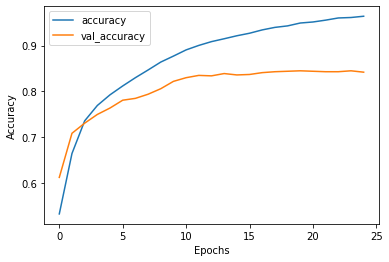

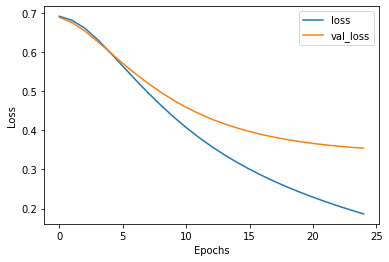

In [20]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [21]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)

In [22]:
examples = ['this movie was very, very good', 'quite ok', 'the movie was not bad', 'bad', 'negative disappointed bad scary', 'this movie was stupid']

results = export_model.predict(examples, verbose=False)

for result, example in zip(results, examples):
    print(f'Result: {result[0]:.3f},   Label: {int(np.round(result[0]))},   Review: {example}')

Result: 0.600,   Label: 1,   Review: this movie was very, very good
Result: 0.512,   Label: 1,   Review: quite ok
Result: 0.405,   Label: 0,   Review: the movie was not bad
Result: 0.447,   Label: 0,   Review: bad
Result: 0.378,   Label: 0,   Review: negative disappointed bad scary
Result: 0.426,   Label: 0,   Review: this movie was stupid
